In [ ]:
#| default_exp sampler.subset

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
from qsample.sampler.tree import Tree, Variable, Constant, Delta
import qsample.math as math
import qsample.utils as utils

from qsample.callbacks import CallbackList
from tqdm.auto import tqdm

import numpy as np

In [ ]:
#| export
class SubsetSampler:
    """Class to represent subset sampler
    
    References
    ----------
    ...
    
    Attributes
    ----------
    protocol : Protocol
        Protocol to sample from
    simulator : StabilizerSimulator or StatevectorSimulator
        Simulator used during sampling
    err_model : ErrorModel
        Error model used during sampling
    err_params : dict
        Physical error rates per faulty partition group at which plots generated.
    p_max : dict
        Error probabilities per faulty partition member (one float per member)
    partitions : dict
        Grouping of faulty circuit elements fore each circuit in protocol
    tree : CountTree
        Tree data structure to keep track of sampled events
    """
    def __init__(self, protocol, simulator, p_max, err_model, err_params=None, L=None):
        """
        Parameters
        ----------
        protocol : Protocol
            The protocol to sample from
        simulator : ChpSimulator or StatevectorSimulator
            The simulator used in sampling process
        p_max : dict
            Physical error rates per faulty partition group at which we sample
        err_model : ErrorModel
            Error model used in sampling process
        err_params : dict
            Physical error rates per faulty partition group at which plots generated.
            Should be less than p_max and it should be checked that at p_max all subsets
            scale similar. Only in this region can we use the subset sampler results.
        """
        self.protocol = protocol
        self.simulator = simulator
        self.err_model = err_model()
        self.p_max = self.__err_params_to_matrix(p_max)
        self.err_params = self.__err_params_to_matrix(err_params)
        
        self.partitions = {cid: self.err_model.group(circuit) for cid, circuit in self.protocol.circuits.items()}
        constants = {cid: math.subset_probs(circuit, self.err_model, self.p_max) for cid, circuit in protocol.circuits.items()}
        self.tree = Tree(constants, L)
      
    def __err_params_to_matrix(self, err_params):
        sorted_params = [err_params[k] for k in self.err_model.groups]
        return np.array(np.broadcast_arrays(*sorted_params)).T
        
    def stats(self, err_params=None):
        """Calculate statistics of sample tree wrt `err_params`
        
        Parameters
        ----------
        err_params : dict or None
            Parameter range wrt to which statistics are calculated
        """                    
        _constants = self.tree.constants
        prob = self.err_params if err_params == None else self.__err_params_to_matrix(err_params)
        self.tree.constants = {cid: math.subset_probs(circuit, self.err_model, prob) for cid, circuit in self.protocol.circuits.items()}

        
        p_L = self.tree.subtree_sum(self.tree.root, self.tree.marked)
        delta = self.tree.delta
        var = self.tree.var(mode=1)
        var_up = self.tree.var(mode=0)
        
        self.tree.constants = _constants
        return np.broadcast_arrays(p_L, np.sqrt(var), p_L+delta, np.sqrt(var_up))
        
    
    def save(self, path):
        utils.save(path)
        
    def _choose_subset(self, tnode, circuit):
        """Choose a subset for `circuit`, based on current `tnode`
        
        Choice is based on subset occurence probability (Aws).
        Exclude 0-weight-subsets if a circuit is fault-free determinstic and
        the 0-weight-subset has already been sampled in the past.
        
        Parameters
        ----------
        tnode : Variable
            Current tree node we want to sample from
        circuit : Circuit
            Current circuit associated with tree node
        
        Returns
        -------
        tuple
            Next subset to choose for `tnode`
        """
        subsets, Aws = zip(*self.tree.constants[circuit.id].items())
        if circuit.ff_deterministic and subsets[0] in {n.name for n in tnode.children}:
            Aws = np.ma.masked_array(Aws)
            Aws[0] = np.ma.masked
        return subsets[ np.random.choice(len(subsets), p=Aws) ]
    
    def __add_virtual_subsets(self, tnode, path_weight):
        """Append subset nodes with 0 count at tnode
        
        For F.T. protocols we know that all paths with a path weight
        up to the F.T. level of the protocol result in a fault-free
        execution. Thus we add virtual subsets to circuit nodes during
        sampling to obtain a more realistic estimate of the cutoff error.
        By "virtual" we denote nodes which have a count of 0 (but anyway
        contribute to the calculation of estimates).
        
        Parameters
        ----------
        tnode : Variable
            Circuit node at which to append subsets
        path_weight : int
            Weight of tree path from root to `tnode`
        """
        circuit = self.protocol.get_circuit(tnode.name)
        delta_weight = (1 if self.protocol.fault_tolerant else 0) - path_weight
        for vsubset in [ss for ss in self.tree.constants[circuit.id].keys() if sum(ss) <= delta_weight]:
            self.tree.add(name=vsubset, parent=tnode, node_type=Constant)
            delta_node = self.tree.add(name='δ', node_type=Delta, parent=tnode, ff=True)
        
    def run(self, n_shots, callbacks=[]):
        """Execute n_shots of subset sampling
        
        Parameters
        ----------
        n_shots : int
            Number of shots sampled in total
        callbacks : list of Callback
            Callback instances executed during sampling
        """
        self.n_shots = n_shots
        
        if not isinstance(callbacks, CallbackList):
            callbacks = CallbackList(sampler=self, callbacks=callbacks)
        
        self.stop_sampling = False # Flag can be controlled in callbacks
        callbacks.on_sampler_begin()
        
        for _ in tqdm(range(n_shots), desc=f"p={tuple(map('{:.2e}'.format, self.p_max))}"):
            callbacks.on_protocol_begin()
            pnode = self.protocol.root # get protocol start node
            state = self.simulator(len(self.protocol.qubits)) # init state
            msmt_hist = {} # init measurement history
            tnode = None # init tree node
            
            while True:
                callbacks.on_circuit_begin()
                
                _pnode = pnode
                pnode, circuit = self.protocol.successor(pnode, msmt_hist)
                tnode = self.tree.add(name=pnode, parent=tnode, node_type=Variable)
                tnode.count += 1
                
                path_weight = self.tree.path_weight(tnode)
                if path_weight == 0:
                    # Nodes along weight-0 path have no variance
                    tnode.invariant = True
                    
                # Add virtual circuit node neighbor node and its virtual subsets
                if path_weight <= (1 if self.protocol.fault_tolerant else 0) and circuit:
                    for vpnode in [n for n in self.protocol.successors(_pnode) if n != pnode]:
                        vcircuit = self.protocol.get_circuit(vpnode)
                        if vcircuit and vcircuit.noisy:
                            vtnode = self.tree.add(name=vpnode, parent=tnode.parent, node_type=Variable, circuit_id=vcircuit.id)
                            path_weight = self.tree.path_weight(vtnode)
                            if path_weight == 0:
                                # Nodes along weight-0 path have no variance
                                vtnode.invariant = True
                            self.__add_virtual_subsets(vtnode, path_weight)
                        
                if circuit:
                
                    tnode.ff_deterministic = circuit.ff_deterministic
                    tnode.circuit_id = circuit.id
                    
                    if not circuit.noisy:
                        msmt = state.run(circuit)
                        tnode.invariant = True
                    else:
                        self.tree.add(name='δ', node_type=Delta, parent=tnode)
                    
                        subset = self._choose_subset(tnode, circuit)
                        fault_locs = self.err_model.choose_w(self.partitions[circuit.id], subset)
                        fault_circuit = self.err_model.run(circuit, fault_locs)
                        msmt = state.run(circuit, fault_circuit)

                        tnode = self.tree.add(name=subset, parent=tnode, node_type=Constant)
                        tnode.count += 1
                        
                        # Add virtual subsets for this circuit node
                        if path_weight <= (1 if self.protocol.fault_tolerant else 0):
                            self.__add_virtual_subsets(tnode.parent, path_weight)
                        
                    msmt = msmt if msmt==None else int(msmt,2) # convert to int for comparison in checks
                    msmt_hist[pnode] = msmt_hist.get(pnode, []) + [msmt]
                else:
                    if path_weight <= (1 if self.protocol.fault_tolerant else 0):
                        # Leaf nodes of fault tolerant paths have not variance
                        tnode.invariant = True
                    if pnode != None:
                        # "Interesting" event happened
                        self.tree.marked.add(tnode)
                    break
                callbacks.on_circuit_end(locals())
                
            callbacks.on_protocol_end()
            if self.stop_sampling:
                break
        del self.stop_sampling
        callbacks.on_sampler_end()

p=('1.00e-02',):   0%|          | 0/100 [00:00<?, ?it/s]

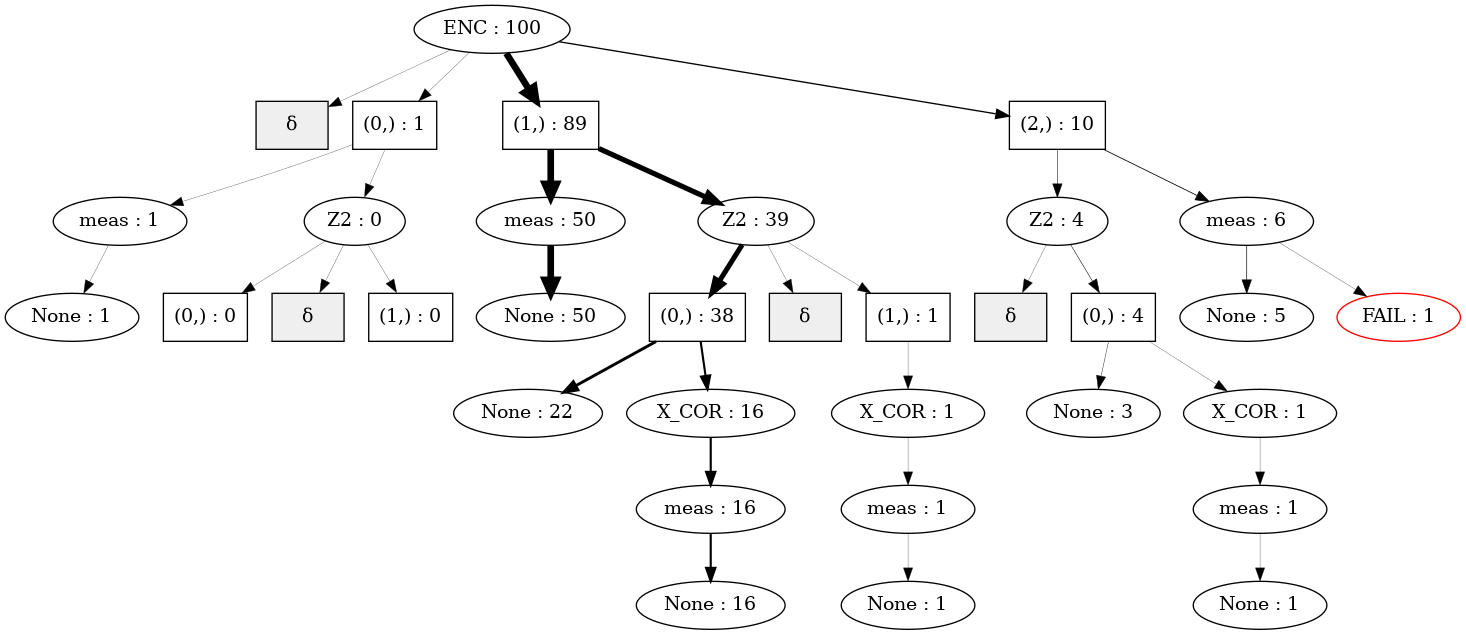

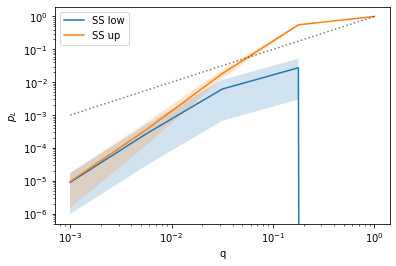

In [ ]:
#| slow

from qsample.examples import ghz1, ghz3, ghz_stab, ftsteane, flagstab, steane0, tele
from qsample.sim.stabilizer import StabilizerSimulator as CHP
from qsample.noise import E1
import qsample.callbacks as cb
from qsample.sampler.experimental import SubsetSamplerERV

sample_range = np.logspace(-3,0,5)
err_params = {'q': sample_range}
p_max = {'q': 0.01}

ss_sam = SubsetSampler(protocol=steane0, simulator=CHP,  p_max=p_max, err_model=E1, err_params=err_params, L=2)
ss_sam.run(100, callbacks=[cb.PlotStats()])

ss_sam.tree.draw(verbose=True)